### LIB (R)

In [1]:
# bibliotecas do python
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# bibliotecas do R
base = importr('base')
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
ts_analysis = ('urca','tseries','forecast','e1071','Metrics')

from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(ts_analysis))

In [6]:
# importando as bibliotecas do R usadas para predição
# acho que so precisa importar uma vez. (demora)

urca = importr('urca')
tseries = importr('tseries')
forecast = importr('forecast')
e1071 = importr('e1071')
metrics = importr('Metrics')
#highcharter = importr('highcharter')

In [7]:
# %R - "linha mágica" - retorna valor como objeto python

# %%R - "célula mágica" - nao retorna valor mas consegue passar input e output  

# Arguments
# -i  -  variaveis de input
# -o  -  variaveis de output
# -h  -  altura do plot
# -w  -  largura do plot


%load_ext rpy2.ipython

In [ ]:
import requests
from datetime import date, datetime
from calendar import timegm

today = date.today()

base = "http://monipe-central.rnp.br"


def get_data(url_slice, time_range):
    url = base+url_slice
    header = {"time-range": time_range}
    response = requests.get(url, params=header)
    json_data = response.json()
    return json_data


def request_by_metadata_key(url, type):
    url_ = url
    response = requests.get(url_)
    json_data = response.json()
    if (response.status_code == 200):
        for obj in json_data["event-types"]:
            if obj["event-type"] == type:
                return obj
    else:highcharter = importr('highcharter')

def calc_mean(val):
    values = []
    for key, value in val.items():
        values.append(float(key)*value)
    return sum(values)/len(values)


def request(name, source, destination, type, time_range, target_bandwidth="9999999999"):
    url = "http://monipe-central.rnp.br/esmond/perfsonar/archive/?"
    hearder = {"pscheduler-test-type": type, "source": source, "destination": destination,
               "bw-target-bandwidth": target_bandwidth, "time-range": time_range}
    response = requests.get(url, params=hearder)
    json_data = response.json()
    if (response.status_code == 200):
        datas = []
        for obj in json_data:
            url_obj = obj["url"]
            get_url_base_obj = request_by_metadata_key(url_obj, type)
            if (not isinstance(get_url_base_obj, int)):
                url_base = get_url_base_obj["base-uri"]
                f = open(name+" esmond data " +
                         today.strftime("%m-%d-%Y")+".csv", "w")
                data = get_data(url_base, time_range)
                datas.insert(0, data)
            else:
                return "Error " + response.status_code
        teste = []
        for i in range(len(datas)):
            cont = 0
            soma = 0
            anterior = None
            for obj in datas[i]:
                data = datetime.fromtimestamp(int(obj["ts"]))
                dia = str(data).split()[0][-2::]
                if (str(data).split()[0][-5::]) not in teste:
                    teste.append(str(data).split()[0][-5::])
                if dia == anterior or anterior is None:
                    soma += obj["val"]
                    cont += 1
                    f.write(datetime.fromtimestamp(int(obj["ts"])).strftime(
                        '%Y-%m-%d %H:%M:%S')+", "+str(obj["val"])+"\n")
                else:
                    media = soma/cont
                    ciclos = 6-cont
                    for i in range(ciclos):
                        cont += 1
                        f.write(datetime.fromtimestamp(
                            int(obj["ts"]-86400)).strftime('%Y-%m-%d %H:%M:%S')+", "+str(media)+"\n")
                    soma = 0
                if cont == 6:
                    cont = 0
                    anterior = None
                else:
                    anterior = dia
        print(len(teste)*6)
        for i in teste:
            print(i)
        f.close()
    else:
        return "Error: " + response.status_code


def request_atraso(name, source, destination, type, time_range):
    url = "http://monipe-central.rnp.br/esmond/perfsonar/archive/?"
    hearder = {"pscheduler-test-type": type, "source": source,
               "destination": destination, "time-range": time_range}
    response = requests.get(url, params=hearder)
    json_data = response.json()
    values = []
    if (response.status_code == 200):
        print("Ok")
        bases = []
        for obj in json_data:
            types_list = obj['event-types']
            for obj_types in types_list:
                if obj_types.get('event-type') == 'histogram-owdelay':
                    bases.append(obj_types.get('base-uri'))
                    break
        with open(name+" esmond data " + today.strftime("%m-%d-%Y")+".csv", "w") as f:
            for link in bases:
                values = get_data(link, time_range)
                for value in values:
                    value['val'] = calc_mean(value['val'])
                    f.write(f"{value['ts']}, {value['val']}\n")


# request("cubic", "monipe-ce-banda.rnp.br", "monipe-sp-banda.rnp.br", "throughput", "15552000") # 6 meses
# request("bbr", "monipe-ce-banda.rnp.br", "monipe-sp-banda.rnp.br", "throughput", "15552000", "10000000000") # 6 meses

request_atraso("atraso", "monipe-ce-atraso.rnp.br",
               "monipe-sp-atraso.rnp.br", "latencybg", "7776000")

### Throughput Total (PRA - Remoção de Erros de Ciclo)

In [156]:
TS = pd.read_csv(r'vazao/cubic esmond data 10-18-2022.csv')
TS2 = pd.read_csv(r'vazao/cubic esmond data 10-18-2022.csv')

TS = TS.iloc[:, 1]
for i in range(len(TS)):
    if TS[i] < 930000000:
        TS = TS.drop(i)
        continue
    if TS[i] > 950000000:
        TS = TS.drop(i)
        continue
print(TS)

0      941674100.0
1      942355627.5
2      942355627.5
3      942355627.5
4      942355627.5
          ...     
830    940420181.0
831    940628564.0
832    940628564.0
833    940628564.0
835    940787044.0
Name:  943037155.0, Length: 752, dtype: float64


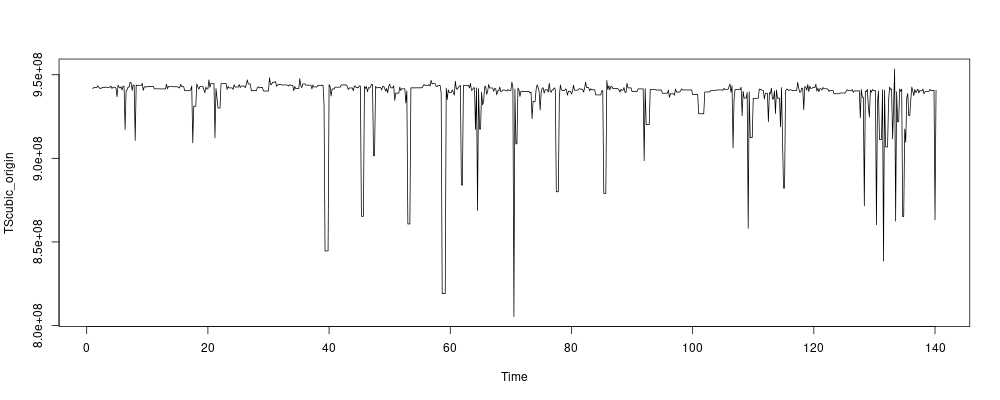

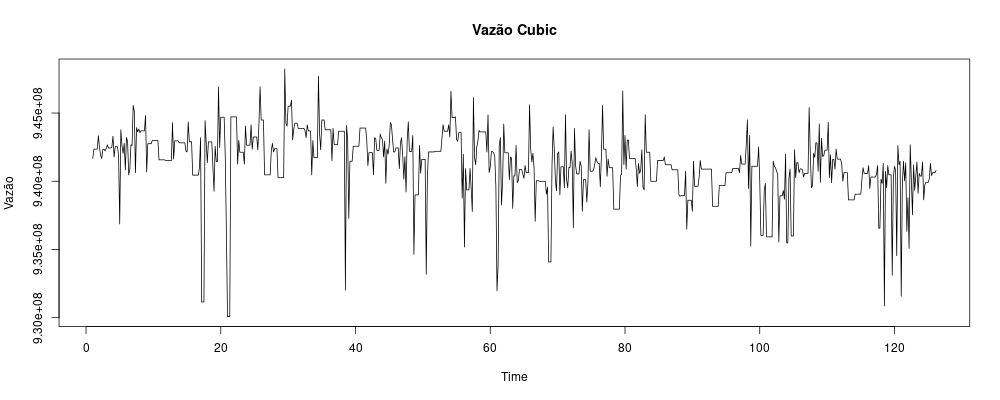

In [157]:
%%R -i TS -i TS2 -h 400 -w 1000 -o TScubic

TS_R = TS
TS_R2 = TS2

TScubic_origin = ts(TS_R2[,2], start = c(1, 1), frequency = 6)
TScubic = ts(TS_R, start = c(1, 1), frequency = 6)
#TScubic_clean = tsclean(TScubic)

#par (mfrow = c(2,1))
plot(TScubic_origin)
plot(TScubic, main = "Vazão Cubic", ylab = "Vazão")
#plot(TScubic_clean, main = "Vazão Cubic", ylab = "Vazão")


In [84]:
%%R

write.csv(TS_R,"\\home\\silvio\\Projetos\\Larces\\PMon2022\\UECE-RNP-PMon2022\\tratados", row.names = FALSE)

### Funcoes para destacar a media e variancia

In [93]:
%%R 

media = function(ts){
  #Média ao longo da série
  y = c()
  cont = 0
  for(i in 1:length(ts)){
    cont = cont + ts[i]
    y = append(y, cont/i)
  }
  med = ts(y, start = c(1, 1), frequency = 6)
  return(med)
}

variancia = function(ts){
  #variância ao longo da série
  y = c()
  for(i in 1:length(ts)){
    y = append(y, var(ts[1:i]))
  }
  var = ts(y, start = c(1, 1), frequency = 6)
  return(var)
}

In [94]:
%%R -w 700 -h 400 # Decomposição da Série (Observação de tendencia e sazonaliadade)

tsadditive = decompose(TScubic, type = "additive")
tsmult = decompose(TScubic, type = "multiplicative")

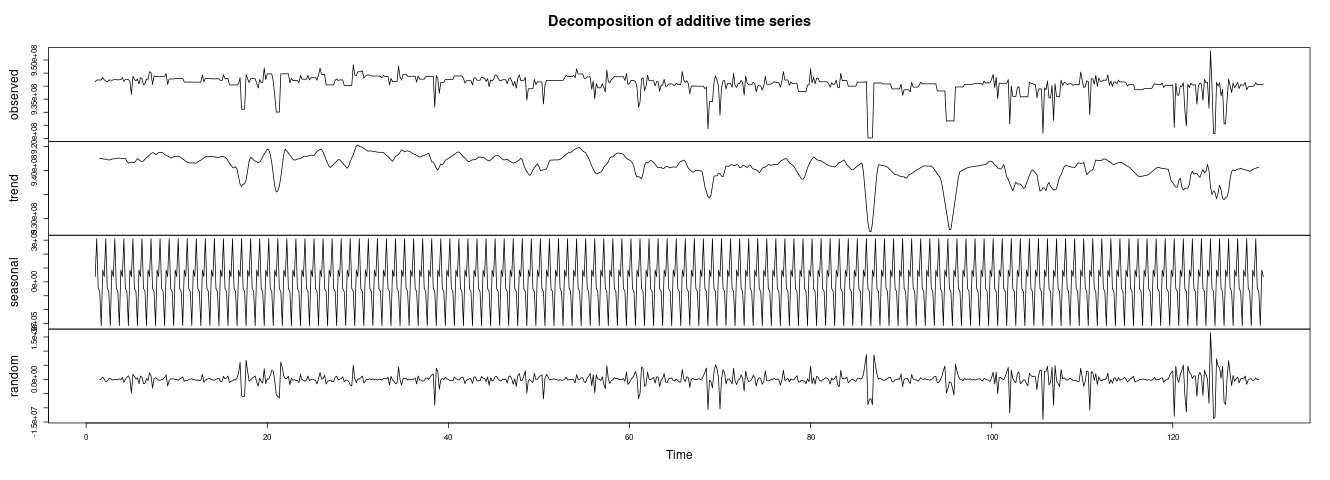

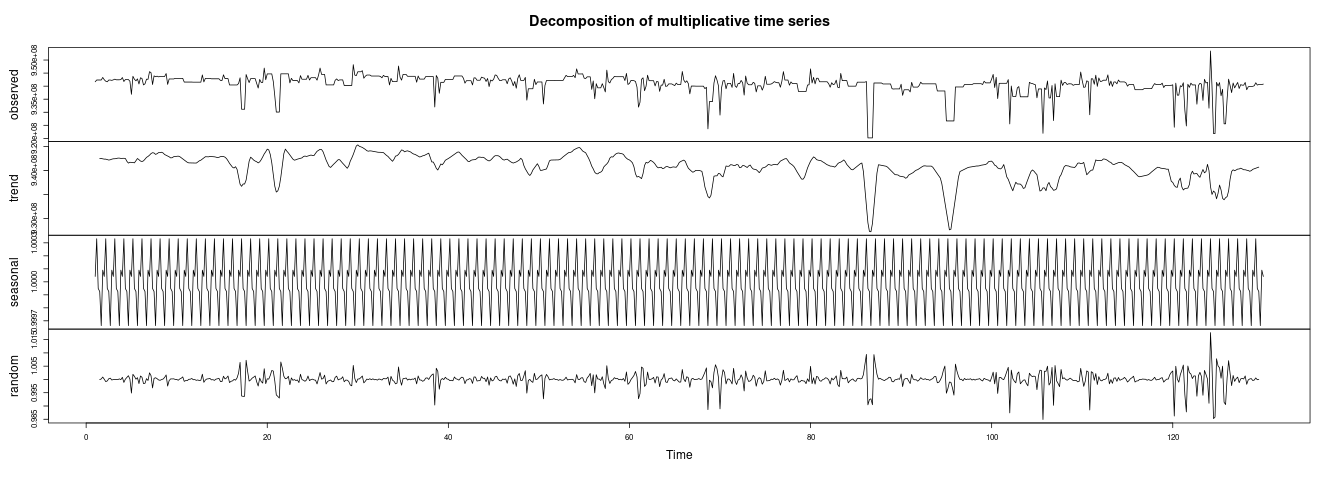

In [96]:
%%R -w 1330

par(mfrow=c(4,1))
plot(tsadditive)
plot(tsmult)

In [98]:
%%R -o random_ad # Variavel aleatoria

random_ad = tsadditive$random
random_mt = tsmult$random

In [99]:
%%R 
random_ad = na.omit(random_ad)
random_mt = na.omit(random_mt)

### Teste de Estacionariedade (Serie Total - Observação)

In [100]:
%%R -h 400 -w 1000 # Teste de estacionariedade para cada tipo de decomposição

kpss_add = ur.kpss(random_ad)
kpss_mul = ur.kpss(random_mt)

adf_add = ur.df(random_ad)
adf_mul = ur.df(random_mt)

In [101]:
%%R

print(kpss_add)
print(kpss_mul)

print(adf_add)
print(adf_mul)

# Usar o TS clean


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.005 


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.005 


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -28.1953 


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -0.0378 



### Separar Conjuntos

In [159]:
%%R # Separar conjuntos de treino

conjunto_treino = c("mytsTrain3", 
                    "mytsTrain6",
                    "mytsTrain9", 
                    "mytsTrain12",
                    "mytsTrain15",
                    "mytsTrain18",
                    "mytsTrain21",
                    "mytsTrain24",
                    "mytsTrain27",
                    "mytsTrain30",
                    "mytsTrain33",
                    "mytsTrain36",
                    "mytsTrain39",
                    "mytsTrain42",
                    "mytsTrain45",
                    "mytsTrain48",
                    "mytsTrain51",
                    "mytsTrain54",
                    "mytsTrain57",
                    "mytsTrain60",
                    "mytsTrain63",
                    "mytsTrain66",
                    "mytsTrain69",
                    "mytsTrain72",
                    "mytsTrain75",
                    "mytsTrain78",
                    "mytsTrain81",
                    "mytsTrain84",
                    "mytsTrain87",
                    "mytsTrain90",
                    "mytsTrain93",
                    "mytsTrain96",
                    "mytsTrain99",
                    "mytsTrain102",
                    "mytsTrain105",
                    "mytsTrain108",
                    "mytsTrain111",
                    "mytsTrain114",
                    "mytsTrain117")

mytsTrain3 = window(TScubic, start = c(1,1), end = c(3,6))
mytsTrain6 = window(TScubic, start = c(1,1), end = c(6,6))
mytsTrain9 = window(TScubic, start = c(1,1), end = c(9,6))
mytsTrain12 = window(TScubic, start = c(1,1), end = c(12,6))
mytsTrain15 = window(TScubic, start = c(1,1), end = c(15,6))
mytsTrain18 = window(TScubic, start = c(1,1), end = c(18,6))
mytsTrain21 = window(TScubic, start = c(1,1), end = c(21,6))
mytsTrain24 = window(TScubic, start = c(1,1), end = c(24,6))
mytsTrain27 = window(TScubic, start = c(1,1), end = c(27,6))
mytsTrain30 = window(TScubic, start = c(1,1), end = c(30,6))
mytsTrain33 = window(TScubic, start = c(1,1), end = c(33,6))
mytsTrain36 = window(TScubic, start = c(1,1), end = c(36,6))
mytsTrain39 = window(TScubic, start = c(1,1), end = c(39,6))
mytsTrain42 = window(TScubic, start = c(1,1), end = c(42,6))
mytsTrain45 = window(TScubic, start = c(1,1), end = c(45,6))
mytsTrain48 = window(TScubic, start = c(1,1), end = c(48,6))
mytsTrain51 = window(TScubic, start = c(1,1), end = c(51,6))
mytsTrain54 = window(TScubic, start = c(1,1), end = c(54,6))
mytsTrain57 = window(TScubic, start = c(1,1), end = c(57,6))
mytsTrain60 = window(TScubic, start = c(1,1), end = c(60,6))
mytsTrain63 = window(TScubic, start = c(1,1), end = c(63,6))
mytsTrain66 = window(TScubic, start = c(1,1), end = c(66,6))
mytsTrain69 = window(TScubic, start = c(1,1), end = c(69,6))
mytsTrain72 = window(TScubic, start = c(1,1), end = c(72,6))
mytsTrain75 = window(TScubic, start = c(1,1), end = c(75,6))
mytsTrain78 = window(TScubic, start = c(1,1), end = c(78,6))
mytsTrain81 = window(TScubic, start = c(1,1), end = c(81,6))
mytsTrain84 = window(TScubic, start = c(1,1), end = c(84,6))
mytsTrain87 = window(TScubic, start = c(1,1), end = c(87,6))
mytsTrain90 = window(TScubic, start = c(1,1), end = c(90,6))
mytsTrain93 = window(TScubic, start = c(1,1), end = c(93,6))
mytsTrain96 = window(TScubic, start = c(1,1), end = c(96,6))
mytsTrain99 = window(TScubic, start = c(1,1), end = c(99,6))
mytsTrain102 = window(TScubic, start = c(1,1), end = c(102,6))
mytsTrain105 = window(TScubic, start = c(1,1), end = c(105,6))
mytsTrain108 = window(TScubic, start = c(1,1), end = c(108,6))
mytsTrain111 = window(TScubic, start = c(1,1), end = c(111,6))
mytsTrain114 = window(TScubic, start = c(1,1), end = c(114,6))
mytsTrain117 = window(TScubic, start = c(1,1), end = c(117,6))
#mytsTrain176 = window(TScubic, start = c(1,1), end = c(176,6))

In [160]:
%%R
mytsTest4 = window(TScubic, start = c(4,1), end = c(4,6))
mytsTest7 = window(TScubic, start = c(7,1), end = c(7,6))
mytsTest10 = window(TScubic, start = c(10,1), end = c(10,6)) 
mytsTest13 = window(TScubic, start = c(13,1), end = c(13,6)) 
mytsTest16 = window(TScubic, start = c(16,1), end = c(16,6)) 
mytsTest19 = window(TScubic, start = c(19,1), end = c(19,6)) 
mytsTest22 = window(TScubic, start = c(22,1), end = c(22,6)) 
mytsTest25 = window(TScubic, start = c(25,1), end = c(25,6))
mytsTest28 = window(TScubic, start = c(28,1), end = c(28,6)) 
mytsTest31 = window(TScubic, start = c(31,1), end = c(31,6)) 
mytsTest34 = window(TScubic, start = c(34,1), end = c(34,6)) 
mytsTest37 = window(TScubic, start = c(37,1), end = c(37,6))
mytsTest40 = window(TScubic, start = c(40,1), end = c(40,6)) 
mytsTest43 = window(TScubic, start = c(43,1), end = c(43,6)) 
mytsTest46 = window(TScubic, start = c(46,1), end = c(46,6)) 
mytsTest49 = window(TScubic, start = c(49,1), end = c(49,6))
mytsTest52 = window(TScubic, start = c(52,1), end = c(52,6)) 
mytsTest55 = window(TScubic, start = c(55,1), end = c(55,6)) 
mytsTest58 = window(TScubic, start = c(58,1), end = c(58,6)) 
mytsTest61 = window(TScubic, start = c(61,1), end = c(61,6))
mytsTest64 = window(TScubic, start = c(64,1), end = c(64,6))
mytsTest67 = window(TScubic, start = c(67,1), end = c(67,6))
mytsTest70 = window(TScubic, start = c(70,1), end = c(70,6))
mytsTest73 = window(TScubic, start = c(73,1), end = c(73,6))
mytsTest76 = window(TScubic, start = c(76,1), end = c(76,6))
mytsTest79 = window(TScubic, start = c(79,1), end = c(79,6))
mytsTest82 = window(TScubic, start = c(82,1), end = c(82,6))
mytsTest85 = window(TScubic, start = c(85,1), end = c(85,6))
mytsTest88 = window(TScubic, start = c(88,1), end = c(88,6))
mytsTest91 = window(TScubic, start = c(91,1), end = c(91,6))
mytsTest94 = window(TScubic, start = c(94,1), end = c(94,6))
mytsTest97 = window(TScubic, start = c(97,1), end = c(97,6))
mytsTest100 = window(TScubic, start = c(100,1), end = c(100,6))
mytsTest103 = window(TScubic, start = c(103,1), end = c(103,6))
mytsTest106 = window(TScubic, start = c(106,1), end = c(106,6))
mytsTest109 = window(TScubic, start = c(109,1), end = c(109,6))
mytsTest112 = window(TScubic, start = c(112,1), end = c(112,6))
mytsTest115 = window(TScubic, start = c(115,1), end = c(115,6))
mytsTest118 = window(TScubic, start = c(118,1), end = c(118,6))
#mytsTest177 = window(TScubic, start = c(176,1), end = c(177,6))

### Teste de Estacionariedade (PRA)

In [161]:
%%R # Testes de Estacionariedade (PRA)

adf_test = conjunto_treino = c(
  adf.test(mytsTrain8)$statistic,
  adf.test(mytsTrain16)$statistic,
  adf.test(mytsTrain24)$statistic,
  adf.test(mytsTrain32)$statistic,
  adf.test(mytsTrain40)$statistic,
  adf.test(mytsTrain48)$statistic,
  adf.test(mytsTrain56)$statistic,
  adf.test(mytsTrain64)$statistic,
  adf.test(mytsTrain72)$statistic,
  adf.test(mytsTrain80)$statistic,
  adf.test(mytsTrain88)$statistic,
  adf.test(mytsTrain96)$statistic,
  adf.test(mytsTrain104)$statistic,
  adf.test(mytsTrain112)$statistic,
  adf.test(mytsTrain120)$statistic,
  adf.test(mytsTrain128)$statistic,
  adf.test(mytsTrain136)$statistic,
  adf.test(mytsTrain144)$statistic,
  adf.test(mytsTrain152)$statistic,
  adf.test(mytsTrain160)$statistic,
  adf.test(mytsTrain168)$statistic
)

R[write to console]: Error in NCOL(x) : object 'mytsTrain8' not found




Error in NCOL(x) : object 'mytsTrain8' not found


RInterpreterError: Failed to parse and evaluate line '# Testes de Estacionariedade (PRA)\nadf_test = conjunto_treino = c(\n  adf.test(mytsTrain8)$statistic,\n  adf.test(mytsTrain16)$statistic,\n  adf.test(mytsTrain24)$statistic,\n  adf.test(mytsTrain32)$statistic,\n  adf.test(mytsTrain40)$statistic,\n  adf.test(mytsTrain48)$statistic,\n  adf.test(mytsTrain56)$statistic,\n  adf.test(mytsTrain64)$statistic,\n  adf.test(mytsTrain72)$statistic,\n  adf.test(mytsTrain80)$statistic,\n  adf.test(mytsTrain88)$statistic,\n  adf.test(mytsTrain96)$statistic,\n  adf.test(mytsTrain104)$statistic,\n  adf.test(mytsTrain112)$statistic,\n  adf.test(mytsTrain120)$statistic,\n  adf.test(mytsTrain128)$statistic,\n  adf.test(mytsTrain136)$statistic,\n  adf.test(mytsTrain144)$statistic,\n  adf.test(mytsTrain152)$statistic,\n  adf.test(mytsTrain160)$statistic,\n  adf.test(mytsTrain168)$statistic\n)\n'.
R error message: "Error in NCOL(x) : object 'mytsTrain8' not found"

In [ ]:
%%R

adf_test_pvalue = conjunto_treino = c(
  adf.test(mytsTrain8)$p.value,
  adf.test(mytsTrain16)$p.value,
  adf.test(mytsTrain24)$p.value,
  adf.test(mytsTrain32)$p.value,
  adf.test(mytsTrain40)$p.value,
  adf.test(mytsTrain48)$p.value,
  adf.test(mytsTrain56)$p.value,
  adf.test(mytsTrain64)$p.value,
  adf.test(mytsTrain72)$p.value,
  adf.test(mytsTrain80)$p.value,
  adf.test(mytsTrain88)$p.value,
  adf.test(mytsTrain96)$p.value,
  adf.test(mytsTrain104)$p.value,
  adf.test(mytsTrain112)$p.value,
  adf.test(mytsTrain120)$p.value,
  adf.test(mytsTrain128)$p.value,
  adf.test(mytsTrain136)$p.value,
  adf.test(mytsTrain144)$p.value,
  adf.test(mytsTrain152)$p.value,
  adf.test(mytsTrain160)$p.value,
  adf.test(mytsTrain168)$p.value
)

In [ ]:
%%R

  kpss_test = conjunto_treino = c(
    kpss.test(mytsTrain8)$statistic,
    kpss.test(mytsTrain16)$statistic,
    kpss.test(mytsTrain24)$statistic,
    kpss.test(mytsTrain32)$statistic,
    kpss.test(mytsTrain40)$statistic,
    kpss.test(mytsTrain48)$statistic,
    kpss.test(mytsTrain56)$statistic,
    kpss.test(mytsTrain64)$statistic,
    kpss.test(mytsTrain72)$statistic,
    kpss.test(mytsTrain80)$statistic,
    kpss.test(mytsTrain88)$statistic,
    kpss.test(mytsTrain96)$statistic,
    kpss.test(mytsTrain104)$statistic,
    kpss.test(mytsTrain112)$statistic,
    kpss.test(mytsTrain120)$statistic,
    kpss.test(mytsTrain128)$statistic,
    kpss.test(mytsTrain136)$statistic,
    kpss.test(mytsTrain144)$statistic,
    kpss.test(mytsTrain152)$statistic,
    kpss.test(mytsTrain160)$statistic,
    kpss.test(mytsTrain168)$statistic
)

In [ ]:
%%R
kpss_test_pvalue = conjunto_treino = c(
    kpss.test(mytsTrain8)$p.value,
    kpss.test(mytsTrain16)$p.value,
    kpss.test(mytsTrain24)$p.value,
    kpss.test(mytsTrain32)$p.value,
    kpss.test(mytsTrain40)$p.value,
    kpss.test(mytsTrain48)$p.value,
    kpss.test(mytsTrain56)$p.value,
    kpss.test(mytsTrain64)$p.value,
    kpss.test(mytsTrain72)$p.value,
    kpss.test(mytsTrain80)$p.value,
    kpss.test(mytsTrain88)$p.value,
    kpss.test(mytsTrain96)$p.value,
    kpss.test(mytsTrain104)$p.value,
    kpss.test(mytsTrain112)$p.value,
    kpss.test(mytsTrain120)$p.value,
    kpss.test(mytsTrain128)$p.value,
    kpss.test(mytsTrain136)$p.value,
    kpss.test(mytsTrain144)$p.value,
    kpss.test(mytsTrain152)$p.value,
    kpss.test(mytsTrain160)$p.value,
    kpss.test(mytsTrain168)$p.value
)

In [ ]:
%%R

testes_estac = data.frame(conjuntos_de_treino = conjunto_treino,
                          ADF_Test = adf_test, ADF_Pvalue = adf_test_pvalue,
                          KPSS_Test = kpss_test, KPSS_Pvalue = kpss_test_pvalue)

testes_estac

   conjuntos_de_treino   ADF_Test ADF_Pvalue   KPSS_Test KPSS_Pvalue
1                  0.1  -4.800590       0.01 0.138889346         0.1
2                  0.1  -7.067552       0.01 0.026301975         0.1
3                  0.1  -8.049383       0.01 0.083470578         0.1
4                  0.1 -10.953528       0.01 0.013258672         0.1
5                  0.1 -10.834487       0.01 0.010885491         0.1
6                  0.1 -11.852743       0.01 0.010088867         0.1
7                  0.1 -12.857976       0.01 0.008678218         0.1
8                  0.1 -13.191824       0.01 0.008129574         0.1
9                  0.1 -13.595086       0.01 0.004994038         0.1
10                 0.1 -13.874567       0.01 0.004524003         0.1
11                 0.1 -13.498999       0.01 0.006024578         0.1
12                 0.1 -14.114491       0.01 0.012322474         0.1
13                 0.1 -15.197734       0.01 0.004542196         0.1
14                 0.1 -15.640431 

‎Caso 1: Ambos os testes concluem que a série não está estacionária - A série não está parada‎

‎Caso 2: Ambos os testes concluem que a série está parada - A série está parada‎

‎Caso 3: KPSS indica estacionária e ADF indica não-estacionária - A série é tendência estacionária. A tendência precisa ser removida para tornar a série estacionária. A série de tendência é verificada para estacionazalidade.‎

‎Caso 4: KPSS indica não-estacionária e ADF indica estacionária - A série é uma diferença estacionária. O diferenciamento deve ser usado para tornar a série estacionária. A série diferenciada é verificada para estacionaza.‎

### Aplicação dos modelos de predição

### Treinamento - (ARIMA, Rede Neural, Holt-Winters)

In [162]:
%%R # Treinamento ARIMA

mytsArima3 = auto.arima(mytsTrain3)
mytsArima6 = auto.arima(mytsTrain6)
mytsArima9 = auto.arima(mytsTrain9)
mytsArima12 = auto.arima(mytsTrain12)
mytsArima15 = auto.arima(mytsTrain15)
mytsArima18 = auto.arima(mytsTrain18)
mytsArima21 = auto.arima(mytsTrain21)
mytsArima24 = auto.arima(mytsTrain24)
mytsArima27 = auto.arima(mytsTrain27)
mytsArima30 = auto.arima(mytsTrain30)
mytsArima33 = auto.arima(mytsTrain33)
mytsArima36 = auto.arima(mytsTrain36)
mytsArima39 = auto.arima(mytsTrain39)
mytsArima42 = auto.arima(mytsTrain42)
mytsArima45 = auto.arima(mytsTrain45)
mytsArima48 = auto.arima(mytsTrain48)
mytsArima51 = auto.arima(mytsTrain51)
mytsArima54 = auto.arima(mytsTrain54)
mytsArima57 = auto.arima(mytsTrain57)
mytsArima60 = auto.arima(mytsTrain60)
mytsArima63 = auto.arima(mytsTrain63)
mytsArima66 = auto.arima(mytsTrain66)
mytsArima69 = auto.arima(mytsTrain69)
mytsArima72 = auto.arima(mytsTrain72)
mytsArima75 = auto.arima(mytsTrain75)
mytsArima78 = auto.arima(mytsTrain78)
mytsArima81 = auto.arima(mytsTrain81)
mytsArima84 = auto.arima(mytsTrain84)
mytsArima87 = auto.arima(mytsTrain87)
mytsArima90 = auto.arima(mytsTrain90)


In [163]:
%%R # Treinamento Neural

mytsNeural3 = nnetar(mytsTrain3)
mytsNeural6 = nnetar(mytsTrain6)
mytsNeural9 = nnetar(mytsTrain9)
mytsNeural12 = nnetar(mytsTrain12)
mytsNeural15 = nnetar(mytsTrain15)
mytsNeural18 = nnetar(mytsTrain18)
mytsNeural21 = nnetar(mytsTrain21)
mytsNeural24 = nnetar(mytsTrain24)
mytsNeural27 = nnetar(mytsTrain27)
mytsNeural30 = nnetar(mytsTrain30)
mytsNeural33 = nnetar(mytsTrain33)
mytsNeural36 = nnetar(mytsTrain36)
mytsNeural39 = nnetar(mytsTrain39)
mytsNeural42 = nnetar(mytsTrain42)
mytsNeural45 = nnetar(mytsTrain45)
mytsNeural48 = nnetar(mytsTrain48)
mytsNeural51 = nnetar(mytsTrain51)
mytsNeural54 = nnetar(mytsTrain54)
mytsNeural57 = nnetar(mytsTrain57)
mytsNeural60 = nnetar(mytsTrain60)
mytsNeural63 = nnetar(mytsTrain63)
mytsNeural66 = nnetar(mytsTrain66)
mytsNeural69 = nnetar(mytsTrain69)
mytsNeural72 = nnetar(mytsTrain72)
mytsNeural75 = nnetar(mytsTrain75)
mytsNeural78 = nnetar(mytsTrain78)
mytsNeural81 = nnetar(mytsTrain81)
mytsNeural84 = nnetar(mytsTrain84)
mytsNeural87 = nnetar(mytsTrain87)
mytsNeural90 = nnetar(mytsTrain90)


In [164]:
%%R # Treinamento Holt-Winters


mytsHoltETS3 = ets(mytsTrain3, model = 'ZAA')
mytsHoltETS6 = ets(mytsTrain6, model = 'ZAA')
mytsHoltETS9 = ets(mytsTrain9, model = 'ZAA')
mytsHoltETS12 = ets(mytsTrain12, model = 'ZAA')
mytsHoltETS15 = ets(mytsTrain15, model = 'ZAA')
mytsHoltETS18 = ets(mytsTrain18, model = 'ZAA')
mytsHoltETS21 = ets(mytsTrain21, model = 'ZAA')
mytsHoltETS24 = ets(mytsTrain24, model = 'ZAA')
mytsHoltETS27 = ets(mytsTrain27, model = 'ZAA')
mytsHoltETS30 = ets(mytsTrain30, model = 'ZAA')
mytsHoltETS33 = ets(mytsTrain33, model = 'ZAA')
mytsHoltETS36 = ets(mytsTrain36, model = 'ZAA')
mytsHoltETS39 = ets(mytsTrain39, model = 'ZAA')
mytsHoltETS42 = ets(mytsTrain42, model = 'ZAA')
mytsHoltETS45 = ets(mytsTrain45, model = 'ZAA')
mytsHoltETS48 = ets(mytsTrain48, model = 'ZAA')
mytsHoltETS51 = ets(mytsTrain51, model = 'ZAA')
mytsHoltETS54 = ets(mytsTrain54, model = 'ZAA')
mytsHoltETS57 = ets(mytsTrain57, model = 'ZAA')
mytsHoltETS60 = ets(mytsTrain60, model = 'ZAA')
mytsHoltETS63 = ets(mytsTrain63, model = 'ZAA')
mytsHoltETS66 = ets(mytsTrain66, model = 'ZAA')
mytsHoltETS69 = ets(mytsTrain69, model = 'ZAA')
mytsHoltETS72 = ets(mytsTrain72, model = 'ZAA')
mytsHoltETS75 = ets(mytsTrain75, model = 'ZAA')
mytsHoltETS78 = ets(mytsTrain78, model = 'ZAA')
mytsHoltETS81 = ets(mytsTrain81, model = 'ZAA')
mytsHoltETS84 = ets(mytsTrain84, model = 'ZAA')
mytsHoltETS87 = ets(mytsTrain87, model = 'ZAA')
mytsHoltETS90 = ets(mytsTrain90, model = 'ZAA')


### Previsões

In [ ]:
%%R # Previsão ARIMA

prevArima3 = forecast(mytsArima3, h=6)
prevArima6 = forecast(mytsArima6, h=6)
prevArima9 = forecast(mytsArima9, h=6)
prevArima12 = forecast(mytsArima12, h=6)
prevArima15 = forecast(mytsArima15, h=6)
prevArima18 = forecast(mytsArima18, h=6)
prevArima21 = forecast(mytsArima21, h=6)
prevArima24 = forecast(mytsArima24, h=6)
prevArima27 = forecast(mytsArima27, h=6)
prevArima30 = forecast(mytsArima30, h=6)
prevArima33 = forecast(mytsArima33, h=6)
prevArima36 = forecast(mytsArima36, h=6)
prevArima39 = forecast(mytsArima39, h=6)
prevArima42 = forecast(mytsArima42, h=6)
prevArima45 = forecast(mytsArima45, h=6)
prevArima48 = forecast(mytsArima48, h=6)
prevArima51 = forecast(mytsArima51, h=6)
prevArima54 = forecast(mytsArima54, h=6)
prevArima57 = forecast(mytsArima57, h=6)
prevArima60 = forecast(mytsArima60, h=6)
prevArima63 = forecast(mytsArima63, h=6)
prevArima66 = forecast(mytsArima66, h=6)
prevArima69 = forecast(mytsArima69, h=6)
prevArima72 = forecast(mytsArima72, h=6)
prevArima75 = forecast(mytsArima75, h=6)
prevArima78 = forecast(mytsArima78, h=6)
prevArima81 = forecast(mytsArima81, h=6)
prevArima84 = forecast(mytsArima84, h=6)
prevArima87 = forecast(mytsArima87, h=6)
prevArima90 = forecast(mytsArima90, h=6)

In [ ]:
%%R # Previsão com Rede Neural

prevNeural3 = forecast(mytsNeural3, h=6)
prevNeural6 = forecast(mytsNeural6, h=6)
prevNeural9 = forecast(mytsNeural9, h=6)
prevNeural12 = forecast(mytsNeural12, h=6)
prevNeural15 = forecast(mytsNeural15, h=6)
prevNeural18 = forecast(mytsNeural18, h=6)
prevNeural21 = forecast(mytsNeural21, h=6)
prevNeural24 = forecast(mytsNeural24, h=6)
prevNeural27 = forecast(mytsNeural27, h=6)
prevNeural30 = forecast(mytsNeural30, h=6)
prevNeural33 = forecast(mytsNeural33, h=6)
prevNeural36 = forecast(mytsNeural36, h=6)
prevNeural39 = forecast(mytsNeural39, h=6)
prevNeural42 = forecast(mytsNeural42, h=6)
prevNeural45 = forecast(mytsNeural45, h=6)
prevNeural48 = forecast(mytsNeural48, h=6)
prevNeural51 = forecast(mytsNeural51, h=6)
prevNeural54 = forecast(mytsNeural54, h=6)
prevNeural57 = forecast(mytsNeural57, h=6)
prevNeural60 = forecast(mytsNeural60, h=6)
prevNeural63 = forecast(mytsNeural63, h=6)
prevNeural66 = forecast(mytsNeural66, h=6)
prevNeural69 = forecast(mytsNeural69, h=6)
prevNeural72 = forecast(mytsNeural72, h=6)
prevNeural75 = forecast(mytsNeural75, h=6)
prevNeural78 = forecast(mytsNeural78, h=6)
prevNeural81 = forecast(mytsNeural81, h=6)
prevNeural84 = forecast(mytsNeural84, h=6)
prevNeural87 = forecast(mytsNeural87, h=6)
prevNeural90 = forecast(mytsNeural90, h=6)

In [ ]:
%%R # Previsões Holt-Winters

prevHoltETS3 = forecast(mytsHoltETS3, h=6)
prevHoltETS6 = forecast(mytsHoltETS6, h=6)
prevHoltETS9 = forecast(mytsHoltETS9, h=6)
prevHoltETS12 = forecast(mytsHoltETS12, h=6)
prevHoltETS15 = forecast(mytsHoltETS15, h=6)
prevHoltETS18 = forecast(mytsHoltETS18, h=6)
prevHoltETS21 = forecast(mytsHoltETS21, h=6)
prevHoltETS24 = forecast(mytsHoltETS24, h=6)
prevHoltETS27 = forecast(mytsHoltETS27, h=6)
prevHoltETS30 = forecast(mytsHoltETS30, h=6)
prevHoltETS33 = forecast(mytsHoltETS33, h=6)
prevHoltETS36 = forecast(mytsHoltETS36, h=6)
prevHoltETS39 = forecast(mytsHoltETS39, h=6)
prevHoltETS42 = forecast(mytsHoltETS42, h=6)
prevHoltETS45 = forecast(mytsHoltETS45, h=6)
prevHoltETS48 = forecast(mytsHoltETS48, h=6)
prevHoltETS51 = forecast(mytsHoltETS51, h=6)
prevHoltETS54 = forecast(mytsHoltETS54, h=6)
prevHoltETS57 = forecast(mytsHoltETS57, h=6)
prevHoltETS60 = forecast(mytsHoltETS60, h=6)
prevHoltETS63 = forecast(mytsHoltETS63, h=6)
prevHoltETS66 = forecast(mytsHoltETS66, h=6)
prevHoltETS69 = forecast(mytsHoltETS69, h=6)
prevHoltETS72 = forecast(mytsHoltETS72, h=6)
prevHoltETS75 = forecast(mytsHoltETS75, h=6)
prevHoltETS78 = forecast(mytsHoltETS78, h=6)
prevHoltETS81 = forecast(mytsHoltETS81, h=6)
prevHoltETS84 = forecast(mytsHoltETS84, h=6)
prevHoltETS87 = forecast(mytsHoltETS87, h=6)
prevHoltETS90 = forecast(mytsHoltETS90, h=6)

### Plots - Comparação de alguns ciclos

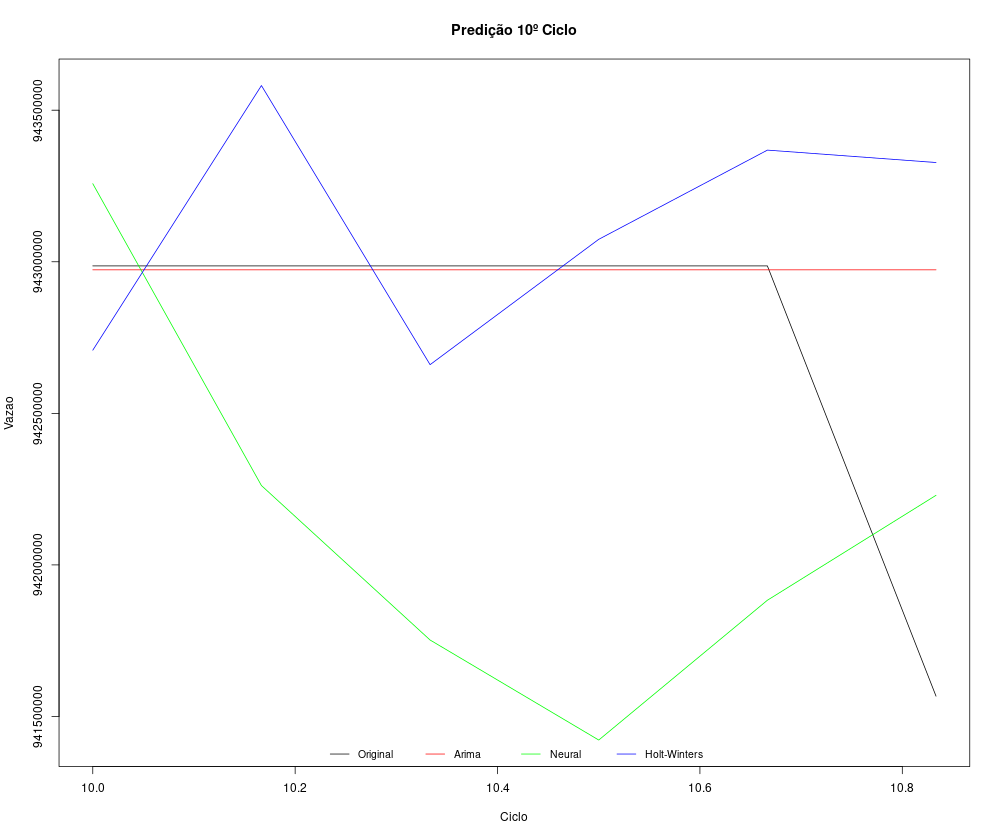

In [ ]:
%%R -h 840 -w 1000 # ciclo 10

mini = min(prevArima9$mean, prevNeural9$mean, prevHoltETS9$mean) - 1000
maxi = max(prevArima9$mean, prevNeural9$mean, prevHoltETS9$mean) + 1000
plot(mytsTest10, main= "Predição 10º Ciclo", xlab="Ciclo", ylab="Vazao", ylim=c(mini, maxi))
lines(prevArima9$mean, col="red")
lines(prevNeural9$mean, col="green")
lines(prevHoltETS9$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

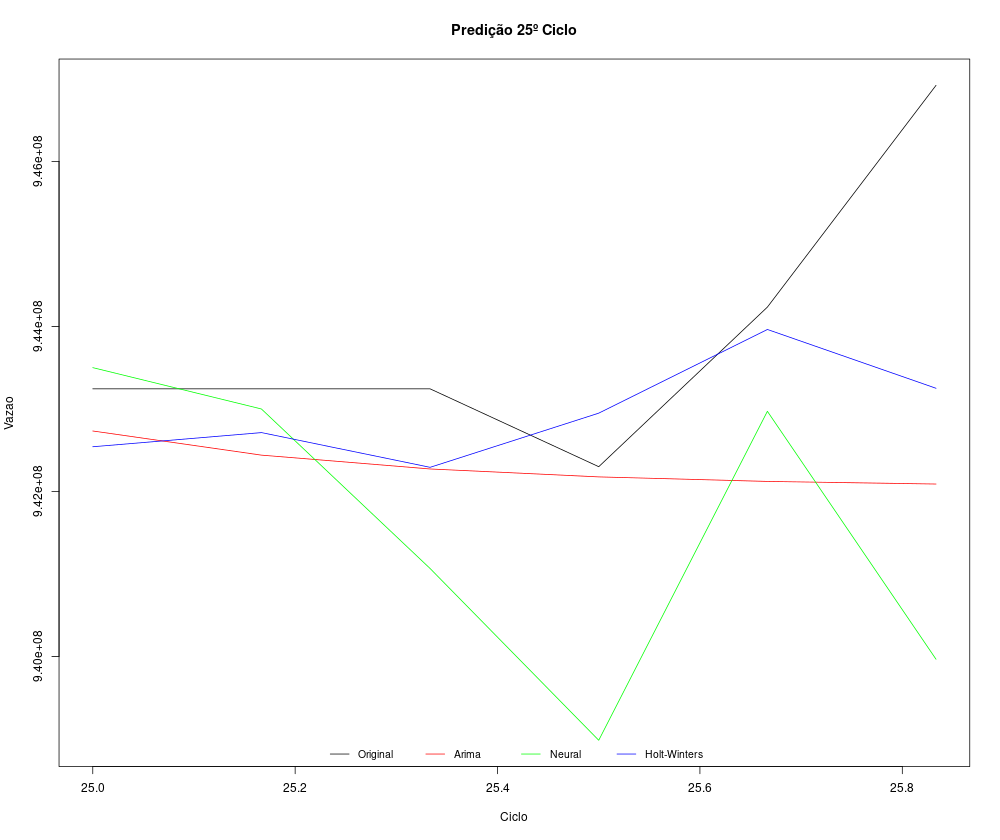

In [ ]:
%%R -h 840 -w 1000 # ciclo 10

mini = min(prevArima24$mean, prevNeural24$mean, prevHoltETS24$mean, mytsTest25) - 1000
maxi = max(prevArima24$mean, prevNeural24$mean, prevHoltETS24$mean, mytsTest25) + 1000
plot(mytsTest25, main= "Predição 25º Ciclo", xlab="Ciclo", ylab="Vazao", ylim=c(mini, maxi))
lines(prevArima24$mean, col="red")
lines(prevNeural24$mean, col="green")
lines(prevHoltETS24$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

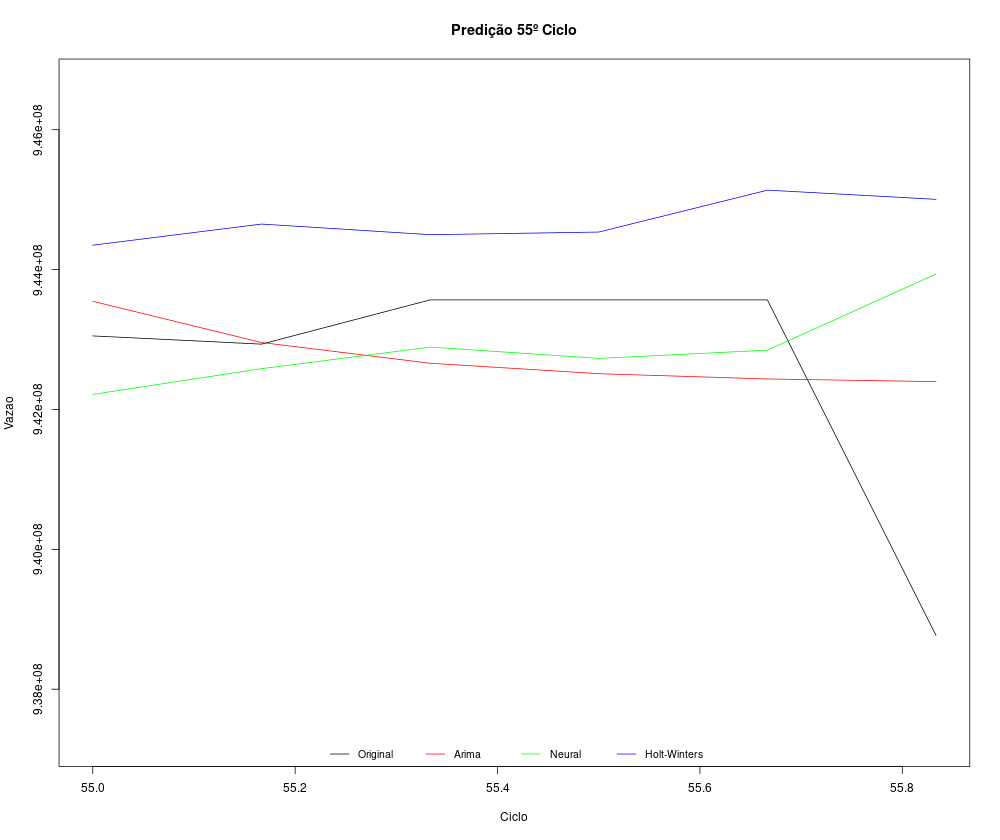

In [ ]:
%%R -h 840 -w 1000 # ciclo 10

mini = min(prevArima54$mean, prevNeural54$mean, prevHoltETS54$mean, mytsTest55) - 1500000
maxi = max(prevArima54$mean, prevNeural54$mean, prevHoltETS54$mean, mytsTest55) + 1500000
plot(mytsTest55, main= "Predição 55º Ciclo", xlab="Ciclo", ylab="Vazao", ylim=c(mini, maxi))
lines(prevArima54$mean, col="red")
lines(prevNeural54$mean, col="green")
lines(prevHoltETS54$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

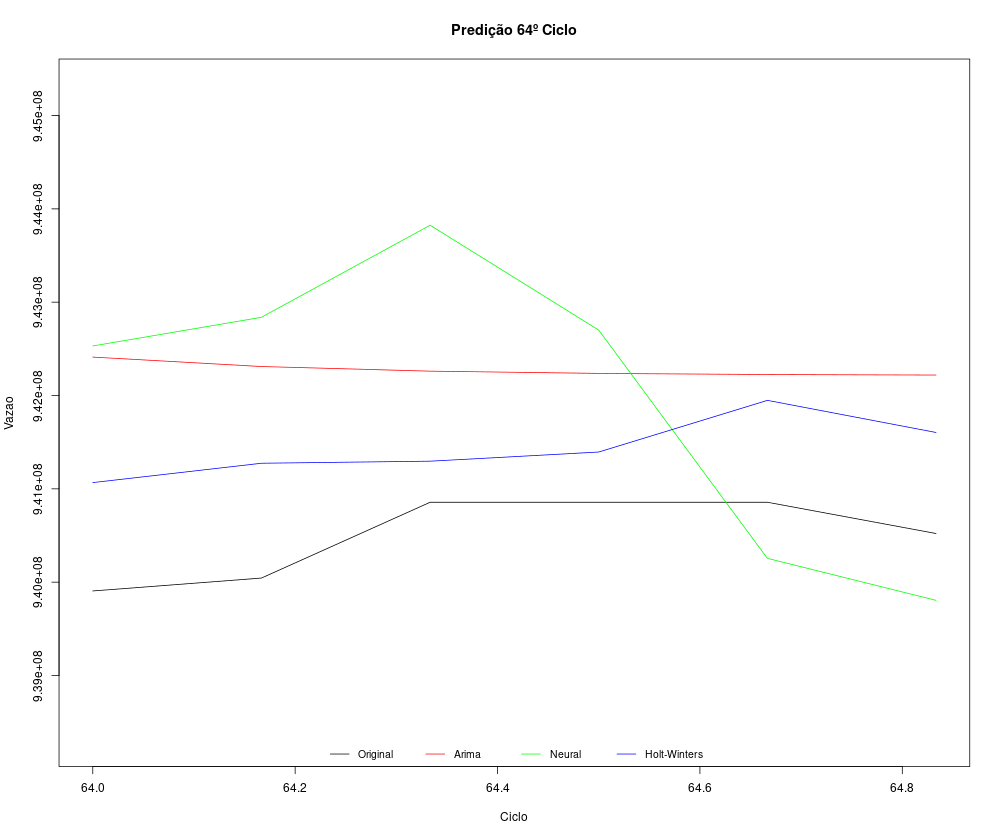

In [ ]:
%%R -h 840 -w 1000 # ciclo 10

mini = min(prevArima63$mean, prevNeural63$mean, prevHoltETS63$mean, mytsTest64) - 1500000
maxi = max(prevArima63$mean, prevNeural63$mean, prevHoltETS63$mean, mytsTest64) + 1500000
plot(mytsTest64, main= "Predição 64º Ciclo", xlab="Ciclo", ylab="Vazao", ylim=c(mini, maxi))
lines(prevArima63$mean, col="red")
lines(prevNeural63$mean, col="green")
lines(prevHoltETS63$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

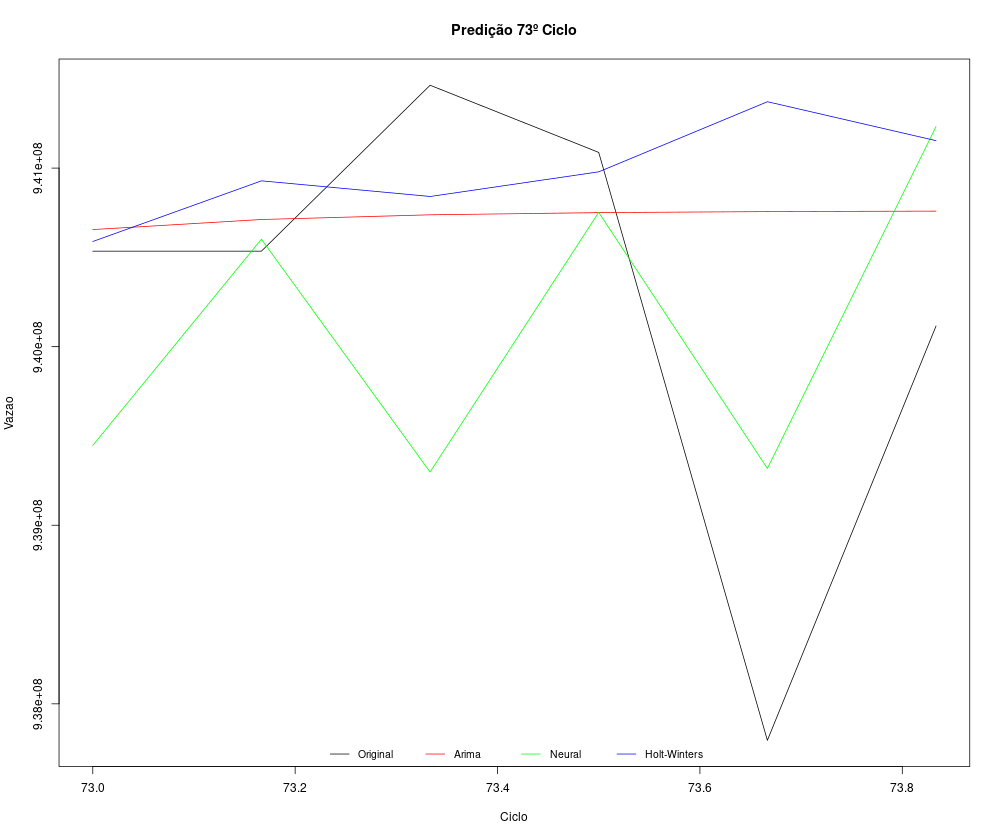

In [ ]:
%%R -h 840 -w 1000 # ciclo 10

mini = min(prevArima72$mean, prevNeural72$mean, prevHoltETS72$mean, mytsTest73)
maxi = max(prevArima72$mean, prevNeural72$mean, prevHoltETS72$mean, mytsTest73)
plot(mytsTest73, main= "Predição 73º Ciclo", xlab="Ciclo", ylab="Vazao", ylim=c(mini, maxi))
lines(prevArima72$mean, col="red")
lines(prevNeural72$mean, col="green")
lines(prevHoltETS72$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

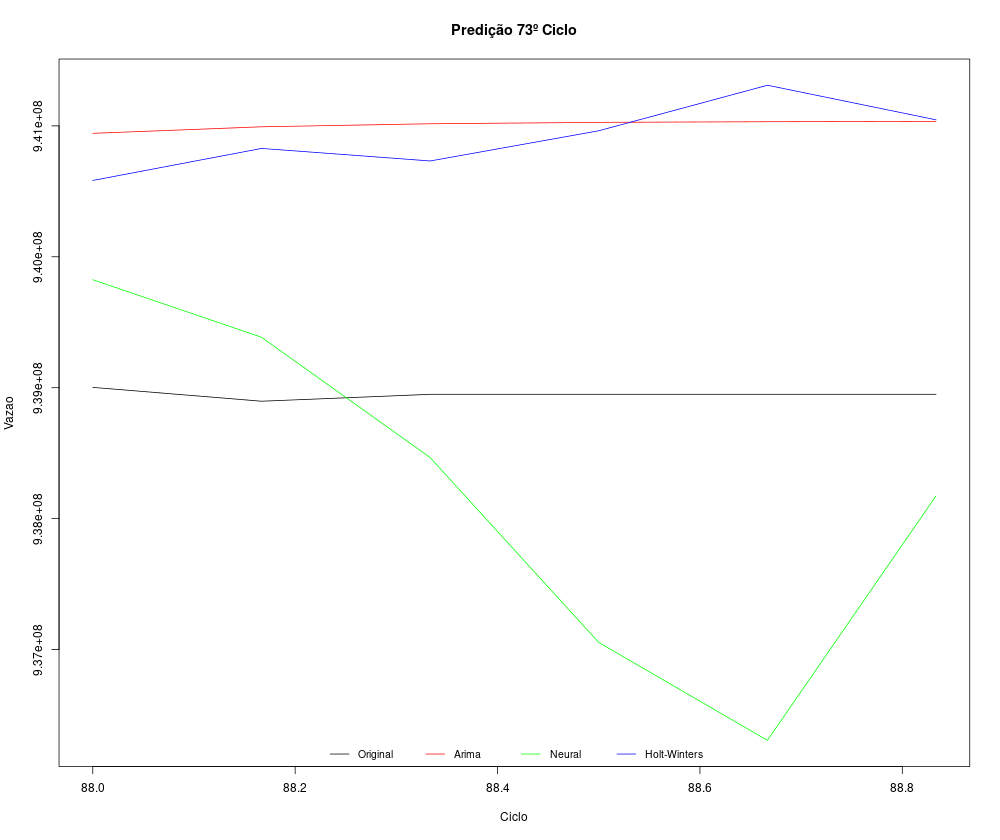

In [ ]:
%%R -h 840 -w 1000 # ciclo 10

mini = min(prevArima87$mean, prevNeural87$mean, prevHoltETS87$mean, mytsTest88)
maxi = max(prevArima87$mean, prevNeural87$mean, prevHoltETS87$mean, mytsTest88)
plot(mytsTest88, main= "Predição 73º Ciclo", xlab="Ciclo", ylab="Vazao", ylim=c(mini, maxi))
lines(prevArima87$mean, col="red")
lines(prevNeural87$mean, col="green")
lines(prevHoltETS87$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

## Avaliação - RMSE e MAPE

### RMSE

 [1] 132.34325 220.63050  99.28071 491.17314 215.19755 227.70338 173.73730
 [8] 126.21538 232.44279 436.81081 235.97551 304.27828 143.35402


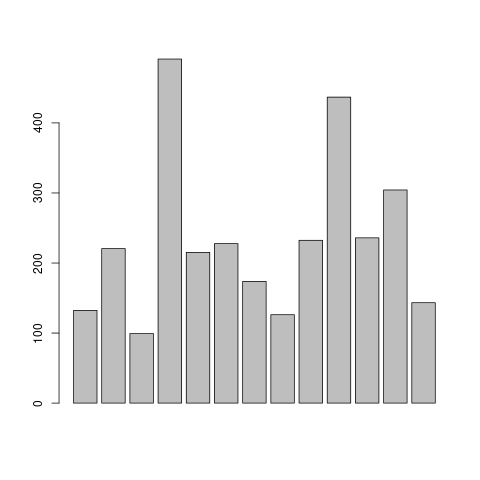

In [207]:
%%R

Neural_RMSE = c(
  rmse(mytsTest52, prevNeural51$mean)/10000,
  rmse(mytsTest55, prevNeural54$mean)/10000,
  rmse(mytsTest58, prevNeural57$mean)/10000,
  rmse(mytsTest61, prevNeural60$mean)/10000,
  rmse(mytsTest64, prevNeural63$mean)/10000,
  rmse(mytsTest67, prevNeural66$mean)/10000,
  rmse(mytsTest70, prevNeural69$mean)/10000,
  rmse(mytsTest73, prevNeural72$mean)/10000,
  rmse(mytsTest76, prevNeural75$mean)/10000,
  rmse(mytsTest79, prevNeural78$mean)/10000,
  rmse(mytsTest82, prevNeural81$mean)/10000,
  rmse(mytsTest85, prevNeural84$mean)/10000,
  rmse(mytsTest88, prevNeural87$mean)/10000
)

print(Neural_RMSE)
barplot(Neural_RMSE)

## Avaliaçōes Sem PRA

### Treinamento sem PRA


In [208]:
%%R

conjunto_treino_without_PRA = c("mytsTrain_without_PRA3", 
                    "mytsTrain_without_PRA6",
                    "mytsTrain_without_PRA9", 
                    "mytsTrain_without_PRA12",
                    "mytsTrain_without_PRA15",
                    "mytsTrain_without_PRA18",
                    "mytsTrain_without_PRA21",
                    "mytsTrain_without_PRA24",
                    "mytsTrain_without_PRA27",
                    "mytsTrain_without_PRA30",
                    "mytsTrain_without_PRA33",
                    "mytsTrain_without_PRA36",
                    "mytsTrain_without_PRA39",
                    "mytsTrain_without_PRA42",
                    "mytsTrain_without_PRA45",
                    "mytsTrain_without_PRA48",
                    "mytsTrain_without_PRA51",
                    "mytsTrain_without_PRA54",
                    "mytsTrain_without_PRA57",
                    "mytsTrain_without_PRA60",
                    "mytsTrain_without_PRA63",
                    "mytsTrain_without_PRA66",
                    "mytsTrain_without_PRA69",
                    "mytsTrain_without_PRA72",
                    "mytsTrain_without_PRA75",
                    "mytsTrain_without_PRA78",
                    "mytsTrain_without_PRA81",
                    "mytsTrain_without_PRA84",
                    "mytsTrain_without_PRA87",
                    "mytsTrain_without_PRA90")
                    #"mytsTrain144")


mytsTrain_without_PRA3 = window(TScubic_origin, start = c(1,1), end = c(3,6))
mytsTrain_without_PRA6 = window(TScubic_origin, start = c(1,1), end = c(6,6))
mytsTrain_without_PRA9 = window(TScubic_origin, start = c(1,1), end = c(9,6))
mytsTrain_without_PRA12 = window(TScubic_origin, start = c(1,1), end = c(12,6))
mytsTrain_without_PRA15 = window(TScubic_origin, start = c(1,1), end = c(15,6))
mytsTrain_without_PRA18 = window(TScubic_origin, start = c(1,1), end = c(18,6))
mytsTrain_without_PRA21 = window(TScubic_origin, start = c(1,1), end = c(21,6))
mytsTrain_without_PRA24 = window(TScubic_origin, start = c(1,1), end = c(24,6))
mytsTrain_without_PRA27 = window(TScubic_origin, start = c(1,1), end = c(27,6))
mytsTrain_without_PRA30 = window(TScubic_origin, start = c(1,1), end = c(30,6))
mytsTrain_without_PRA33 = window(TScubic_origin, start = c(1,1), end = c(33,6))
mytsTrain_without_PRA36 = window(TScubic_origin, start = c(1,1), end = c(36,6))
mytsTrain_without_PRA39 = window(TScubic_origin, start = c(1,1), end = c(39,6))
mytsTrain_without_PRA42 = window(TScubic_origin, start = c(1,1), end = c(42,6))
mytsTrain_without_PRA45 = window(TScubic_origin, start = c(1,1), end = c(45,6))
mytsTrain_without_PRA48 = window(TScubic_origin, start = c(1,1), end = c(48,6))
mytsTrain_without_PRA51 = window(TScubic_origin, start = c(1,1), end = c(51,6))
mytsTrain_without_PRA54 = window(TScubic_origin, start = c(1,1), end = c(54,6))
mytsTrain_without_PRA57 = window(TScubic_origin, start = c(1,1), end = c(57,6))
mytsTrain_without_PRA60 = window(TScubic_origin, start = c(1,1), end = c(60,6))
mytsTrain_without_PRA63 = window(TScubic_origin, start = c(1,1), end = c(63,6))
mytsTrain_without_PRA66 = window(TScubic_origin, start = c(1,1), end = c(66,6))
mytsTrain_without_PRA69 = window(TScubic_origin, start = c(1,1), end = c(69,6))
mytsTrain_without_PRA72 = window(TScubic_origin, start = c(1,1), end = c(72,6))
mytsTrain_without_PRA75 = window(TScubic_origin, start = c(1,1), end = c(75,6))
mytsTrain_without_PRA78 = window(TScubic_origin, start = c(1,1), end = c(78,6))
mytsTrain_without_PRA81 = window(TScubic_origin, start = c(1,1), end = c(81,6))
mytsTrain_without_PRA84 = window(TScubic_origin, start = c(1,1), end = c(84,6))
mytsTrain_without_PRA87 = window(TScubic_origin, start = c(1,1), end = c(87,6))
mytsTrain_without_PRA90 = window(TScubic_origin, start = c(1,1), end = c(90,6))

In [209]:
%%R 

mytsTest_without_PRA4 = window(TScubic_origin, start = c(4,1), end = c(4,6))
mytsTest_without_PRA7 = window(TScubic_origin, start = c(7,1), end = c(7,6))
mytsTest_without_PRA10 = window(TScubic_origin, start = c(10,1), end = c(10,6)) 
mytsTest_without_PRA13 = window(TScubic_origin, start = c(13,1), end = c(13,6)) 
mytsTest_without_PRA16 = window(TScubic_origin, start = c(16,1), end = c(16,6)) 
mytsTest_without_PRA19 = window(TScubic_origin, start = c(19,1), end = c(19,6)) 
mytsTest_without_PRA22 = window(TScubic_origin, start = c(22,1), end = c(22,6)) 
mytsTest_without_PRA25 = window(TScubic_origin, start = c(25,1), end = c(25,6))
mytsTest_without_PRA28 = window(TScubic_origin, start = c(28,1), end = c(28,6)) 
mytsTest_without_PRA31 = window(TScubic_origin, start = c(31,1), end = c(31,6)) 
mytsTest_without_PRA34 = window(TScubic_origin, start = c(34,1), end = c(34,6)) 
mytsTest_without_PRA37 = window(TScubic_origin, start = c(37,1), end = c(37,6))
mytsTest_without_PRA40 = window(TScubic_origin, start = c(40,1), end = c(40,6)) 
mytsTest_without_PRA43 = window(TScubic_origin, start = c(43,1), end = c(43,6)) 
mytsTest_without_PRA46 = window(TScubic_origin, start = c(46,1), end = c(46,6)) 
mytsTest_without_PRA49 = window(TScubic_origin, start = c(49,1), end = c(49,6))
mytsTest_without_PRA52 = window(TScubic_origin, start = c(52,1), end = c(52,6)) 
mytsTest_without_PRA55 = window(TScubic_origin, start = c(55,1), end = c(55,6)) 
mytsTest_without_PRA58 = window(TScubic_origin, start = c(58,1), end = c(58,6)) 
mytsTest_without_PRA61 = window(TScubic_origin, start = c(61,1), end = c(61,6))
mytsTest_without_PRA64 = window(TScubic_origin, start = c(64,1), end = c(64,6))
mytsTest_without_PRA67 = window(TScubic_origin, start = c(67,1), end = c(67,6))
mytsTest_without_PRA70 = window(TScubic_origin, start = c(70,1), end = c(70,6))
mytsTest_without_PRA73 = window(TScubic_origin, start = c(73,1), end = c(73,6))
mytsTest_without_PRA76 = window(TScubic_origin, start = c(76,1), end = c(76,6))
mytsTest_without_PRA79 = window(TScubic_origin, start = c(79,1), end = c(79,6))
mytsTest_without_PRA82 = window(TScubic_origin, start = c(82,1), end = c(82,6))
mytsTest_without_PRA85 = window(TScubic_origin, start = c(85,1), end = c(85,6))
mytsTest_without_PRA88 = window(TScubic_origin, start = c(88,1), end = c(88,6))
mytsTest_without_PRA91 = window(TScubic_origin, start = c(91,1), end = c(91,6))
#mytsTest145 = window(TScubic_origin, start = c(145,1), end = c(145,6))


In [210]:
%%R # Treinamento Arima

mytsArima_without_PRA51 = auto.arima(mytsTrain_without_PRA51)
mytsArima_without_PRA54 = auto.arima(mytsTrain_without_PRA54)
mytsArima_without_PRA57 = auto.arima(mytsTrain_without_PRA57)
mytsArima_without_PRA60 = auto.arima(mytsTrain_without_PRA60)
mytsArima_without_PRA63 = auto.arima(mytsTrain_without_PRA63)
mytsArima_without_PRA66 = auto.arima(mytsTrain_without_PRA66)
mytsArima_without_PRA69 = auto.arima(mytsTrain_without_PRA69)
mytsArima_without_PRA72 = auto.arima(mytsTrain_without_PRA72)
mytsArima_without_PRA75 = auto.arima(mytsTrain_without_PRA75)
mytsArima_without_PRA78 = auto.arima(mytsTrain_without_PRA78)
mytsArima_without_PRA81 = auto.arima(mytsTrain_without_PRA81)
mytsArima_without_PRA84 = auto.arima(mytsTrain_without_PRA84)
mytsArima_without_PRA87 = auto.arima(mytsTrain_without_PRA87)
mytsArima_without_PRA90 = auto.arima(mytsTrain_without_PRA90)

In [211]:
%%R # Treinamento Holt-Winters

mytsHoltETS_without_PRA51 = ets(mytsTrain_without_PRA51, model = 'ZAA')
mytsHoltETS_without_PRA54 = ets(mytsTrain_without_PRA54, model = 'ZAA')
mytsHoltETS_without_PRA57 = ets(mytsTrain_without_PRA57, model = 'ZAA')
mytsHoltETS_without_PRA60 = ets(mytsTrain_without_PRA60, model = 'ZAA')
mytsHoltETS_without_PRA63 = ets(mytsTrain_without_PRA63, model = 'ZAA')
mytsHoltETS_without_PRA66 = ets(mytsTrain_without_PRA66, model = 'ZAA')
mytsHoltETS_without_PRA69 = ets(mytsTrain_without_PRA69, model = 'ZAA')
mytsHoltETS_without_PRA72 = ets(mytsTrain_without_PRA72, model = 'ZAA')
mytsHoltETS_without_PRA75 = ets(mytsTrain_without_PRA75, model = 'ZAA')
mytsHoltETS_without_PRA78 = ets(mytsTrain_without_PRA78, model = 'ZAA')
mytsHoltETS_without_PRA81 = ets(mytsTrain_without_PRA81, model = 'ZAA')
mytsHoltETS_without_PRA84 = ets(mytsTrain_without_PRA84, model = 'ZAA')
mytsHoltETS_without_PRA87 = ets(mytsTrain_without_PRA87, model = 'ZAA')
mytsHoltETS_without_PRA90 = ets(mytsTrain_without_PRA90, model = 'ZAA')

In [212]:
%%R # Treinamento Neural

mytsNeural_without_PRA51 = nnetar(mytsTrain_without_PRA51)
mytsNeural_without_PRA54 = nnetar(mytsTrain_without_PRA54)
mytsNeural_without_PRA57 = nnetar(mytsTrain_without_PRA57)
mytsNeural_without_PRA60 = nnetar(mytsTrain_without_PRA60)
mytsNeural_without_PRA63 = nnetar(mytsTrain_without_PRA63)
mytsNeural_without_PRA66 = nnetar(mytsTrain_without_PRA66)
mytsNeural_without_PRA69 = nnetar(mytsTrain_without_PRA69)
mytsNeural_without_PRA72 = nnetar(mytsTrain_without_PRA72)
mytsNeural_without_PRA75 = nnetar(mytsTrain_without_PRA75)
mytsNeural_without_PRA78 = nnetar(mytsTrain_without_PRA78)
mytsNeural_without_PRA81 = nnetar(mytsTrain_without_PRA81)
mytsNeural_without_PRA84 = nnetar(mytsTrain_without_PRA84)
mytsNeural_without_PRA87 = nnetar(mytsTrain_without_PRA87)
mytsNeural_without_PRA90 = nnetar(mytsTrain_without_PRA90)

In [213]:
%%R # Previsão Arima

prevArima_without_PRA51 = forecast(mytsArima_without_PRA51, h=6)
prevArima_without_PRA54 = forecast(mytsArima_without_PRA54, h=6)
prevArima_without_PRA57 = forecast(mytsArima_without_PRA57, h=6)
prevArima_without_PRA60 = forecast(mytsArima_without_PRA60, h=6)
prevArima_without_PRA63 = forecast(mytsArima_without_PRA63, h=6)
prevArima_without_PRA66 = forecast(mytsArima_without_PRA66, h=6)
prevArima_without_PRA69 = forecast(mytsArima_without_PRA69, h=6)
prevArima_without_PRA72 = forecast(mytsArima_without_PRA72, h=6)
prevArima_without_PRA75 = forecast(mytsArima_without_PRA75, h=6)
prevArima_without_PRA78 = forecast(mytsArima_without_PRA78, h=6)
prevArima_without_PRA81 = forecast(mytsArima_without_PRA81, h=6)
prevArima_without_PRA84 = forecast(mytsArima_without_PRA84, h=6)
prevArima_without_PRA87 = forecast(mytsArima_without_PRA87, h=6)
prevArima_without_PRA90 = forecast(mytsArima_without_PRA90, h=6)

In [214]:
%%R # Previsão com Rede Neural

prevNeural_without_PRA51 = forecast(mytsNeural_without_PRA51, h=6)
prevNeural_without_PRA54 = forecast(mytsNeural_without_PRA54, h=6)
prevNeural_without_PRA57 = forecast(mytsNeural_without_PRA57, h=6)
prevNeural_without_PRA60 = forecast(mytsNeural_without_PRA60, h=6)
prevNeural_without_PRA63 = forecast(mytsNeural_without_PRA63, h=6)
prevNeural_without_PRA66 = forecast(mytsNeural_without_PRA66, h=6)
prevNeural_without_PRA69 = forecast(mytsNeural_without_PRA69, h=6)
prevNeural_without_PRA72 = forecast(mytsNeural_without_PRA72, h=6)
prevNeural_without_PRA75 = forecast(mytsNeural_without_PRA75, h=6)
prevNeural_without_PRA78 = forecast(mytsNeural_without_PRA78, h=6)
prevNeural_without_PRA81 = forecast(mytsNeural_without_PRA81, h=6)
prevNeural_without_PRA84 = forecast(mytsNeural_without_PRA84, h=6)
prevNeural_without_PRA87 = forecast(mytsNeural_without_PRA87, h=6)
prevNeural_without_PRA90 = forecast(mytsNeural_without_PRA90, h=6)

In [215]:
%%R # Previsões Holt-Winters

prevHoltETS_without_PRA51 = forecast(mytsHoltETS_without_PRA51, h=6)
prevHoltETS_without_PRA54 = forecast(mytsHoltETS_without_PRA54, h=6)
prevHoltETS_without_PRA57 = forecast(mytsHoltETS_without_PRA57, h=6)
prevHoltETS_without_PRA60 = forecast(mytsHoltETS_without_PRA60, h=6)
prevHoltETS_without_PRA63 = forecast(mytsHoltETS_without_PRA63, h=6)
prevHoltETS_without_PRA66 = forecast(mytsHoltETS_without_PRA66, h=6)
prevHoltETS_without_PRA69 = forecast(mytsHoltETS_without_PRA69, h=6)
prevHoltETS_without_PRA72 = forecast(mytsHoltETS_without_PRA72, h=6)
prevHoltETS_without_PRA75 = forecast(mytsHoltETS_without_PRA75, h=6)
prevHoltETS_without_PRA78 = forecast(mytsHoltETS_without_PRA78, h=6)
prevHoltETS_without_PRA81 = forecast(mytsHoltETS_without_PRA81, h=6)
prevHoltETS_without_PRA84 = forecast(mytsHoltETS_without_PRA84, h=6)
prevHoltETS_without_PRA87 = forecast(mytsHoltETS_without_PRA87, h=6)
prevHoltETS_without_PRA90 = forecast(mytsHoltETS_without_PRA90, h=6)

### RMSE

In [216]:
%%R

Neural_without_PRA_RMSE = c(
  rmse(mytsTest_without_PRA52, prevNeural_without_PRA51$mean)/10000,
  rmse(mytsTest_without_PRA55, prevNeural_without_PRA54$mean)/10000,
  rmse(mytsTest_without_PRA58, prevNeural_without_PRA57$mean)/10000,
  rmse(mytsTest_without_PRA61, prevNeural_without_PRA60$mean)/10000,
  rmse(mytsTest_without_PRA64, prevNeural_without_PRA63$mean)/10000,
  rmse(mytsTest_without_PRA67, prevNeural_without_PRA66$mean)/10000,
  rmse(mytsTest_without_PRA70, prevNeural_without_PRA69$mean)/10000,
  rmse(mytsTest_without_PRA73, prevNeural_without_PRA72$mean)/10000,
  rmse(mytsTest_without_PRA76, prevNeural_without_PRA75$mean)/10000,
  rmse(mytsTest_without_PRA79, prevNeural_without_PRA78$mean)/10000,
  rmse(mytsTest_without_PRA82, prevNeural_without_PRA81$mean)/10000,
  rmse(mytsTest_without_PRA85, prevNeural_without_PRA84$mean)/10000,
  rmse(mytsTest_without_PRA88, prevNeural_without_PRA87$mean)/10000
)

In [217]:
%%R

Arima_without_PRA_RMSE = c(
  rmse(mytsTest_without_PRA52, prevArima_without_PRA51$mean)/10000,
  rmse(mytsTest_without_PRA55, prevArima_without_PRA54$mean)/10000,
  rmse(mytsTest_without_PRA58, prevArima_without_PRA57$mean)/10000,
  rmse(mytsTest_without_PRA61, prevArima_without_PRA60$mean)/10000,
  rmse(mytsTest_without_PRA64, prevArima_without_PRA63$mean)/10000,
  rmse(mytsTest_without_PRA67, prevArima_without_PRA66$mean)/10000,
  rmse(mytsTest_without_PRA70, prevArima_without_PRA69$mean)/10000,
  rmse(mytsTest_without_PRA73, prevArima_without_PRA72$mean)/10000,
  rmse(mytsTest_without_PRA76, prevArima_without_PRA75$mean)/10000,
  rmse(mytsTest_without_PRA79, prevArima_without_PRA78$mean)/10000,
  rmse(mytsTest_without_PRA82, prevArima_without_PRA81$mean)/10000,
  rmse(mytsTest_without_PRA85, prevArima_without_PRA84$mean)/10000,
  rmse(mytsTest_without_PRA88, prevArima_without_PRA87$mean)/10000
)


In [218]:
%%R

Holt_without_PRA_RMSE = c(
  rmse(mytsTest_without_PRA52, prevHoltETS_without_PRA51$mean)/10000,
  rmse(mytsTest_without_PRA55, prevHoltETS_without_PRA54$mean)/10000,
  rmse(mytsTest_without_PRA58, prevHoltETS_without_PRA57$mean)/10000,
  rmse(mytsTest_without_PRA61, prevHoltETS_without_PRA60$mean)/10000,
  rmse(mytsTest_without_PRA64, prevHoltETS_without_PRA63$mean)/10000,
  rmse(mytsTest_without_PRA67, prevHoltETS_without_PRA66$mean)/10000,
  rmse(mytsTest_without_PRA70, prevHoltETS_without_PRA69$mean)/10000,
  rmse(mytsTest_without_PRA73, prevHoltETS_without_PRA72$mean)/10000,
  rmse(mytsTest_without_PRA76, prevHoltETS_without_PRA75$mean)/10000,
  rmse(mytsTest_without_PRA79, prevHoltETS_without_PRA78$mean)/10000,
  rmse(mytsTest_without_PRA82, prevHoltETS_without_PRA81$mean)/10000,
  rmse(mytsTest_without_PRA85, prevHoltETS_without_PRA84$mean)/10000,
  rmse(mytsTest_without_PRA88, prevHoltETS_without_PRA87$mean)/10000
)


In [ ]:
%%R -w 900

numeroCiclos = c(52, 55, 58, 61, 64, 67, 70, 73,
                 76, 79, 82, 85, 88)

RMSE = data.frame(Observacoes = numeroCiclos, PRA_NeuralRMSE = Neural_RMSE,
                  NeuralRMSE = Neural_without_PRA_RMSE,  PRA_ArimaRMSE = Arima_RMSE,
                  ArimaRMSE = Arima_without_PRA_RMSE, PRA_HoltRMSE = HoltETS_RMSE,
                  HoltRMSE = Holt_without_PRA_RMSE)

colnames(RMSE) = c("Observacoes","RMSE:PRA+Neural", "RMSE:Neural", "RMSE:PRA+Arima",
                   "RMSE:Arima", "RMSE:PRA+HoltWinters", "RMSE:HoltWinters")#, 

highchart() %>% 
  hc_yAxis_multiples(
    list(lineWidth = 1, title=list(text="RMSE"))
  ) %>% 
  hc_add_series(pointWidth=5, name = "PRA+Arima", data = RMSE$`RMSE:PRA+Arima`, color='blue', type = "column") %>% 
  hc_add_series(pointWidth=5, name = "PRA+Neural", data = RMSE$`RMSE:PRA+Neural`, color='gray', type = "column") %>% 
  #hc_add_series(pointWidth=5, name = "PRA+SVM", data = RMSE$`RMSE:PRA+Svm`, color='turquoise', type = "column") %>% 
  hc_add_series(pointWidth=5, name = "PRA+Holt Winter", data = RMSE$`RMSE:PRA+HoltWinters`, color='purple', type = "column") %>%
  hc_add_series(pointWidth=5, name = "Arima", data = RMSE$`RMSE:Arima`, color='black', type = "column") %>% 
  hc_add_series(pointWidth=5, name = "Neural", data = RMSE$`RMSE:Neural`, color='green', type = "column") %>% 
  #hc_add_series(pointWidth=5, name = "SVM", data = RMSE$`RMSE:Svm`, color='coral', type = "column") %>% 
  hc_add_series(pointWidth=5, name = "Holt Winters", data = RMSE$`RMSE:HoltWinters`, color='red', type = "column") %>%
  hc_xAxis(categories = RMSE$Observacoes, title = list(text = "Observações")) %>%
  hc_legend(
    align = "center",
    verticalAlign = "bottom"
  )


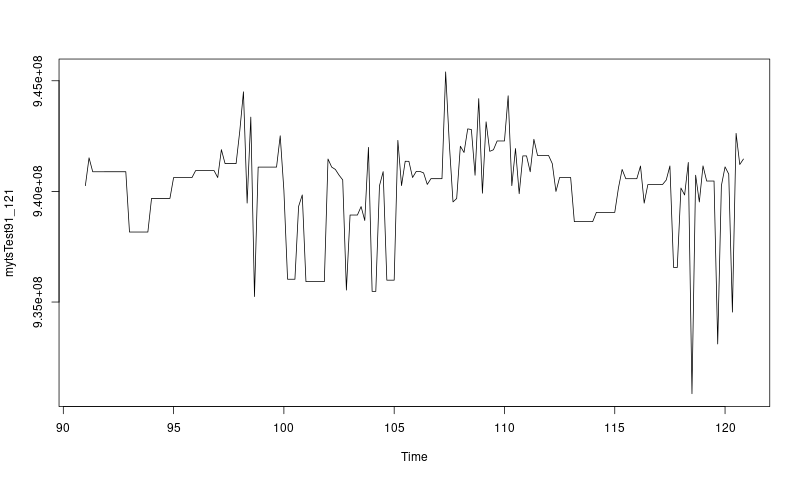

In [220]:
%%R -w 800
mytsTest91_121 = window(TScubic, start = c(91,1), end = c(120,6))
plot(mytsTest91_121)

In [225]:
%%R

## Com PRA
mytsTest91_121 = window(TScubic, start = c(91,1), end = c(120,6))

mytsArima91 = auto.arima(mytsTrain90, d = 1)
mytsHoltETS91 = ets(mytsTrain90, model = 'ZAA')
mytsNeural91 = nnetar(mytsTrain90)

prevArima91_121 = forecast(mytsArima91, h=186)
prevNeural91_121 = forecast(mytsNeural91, h=186)
prevHoltETS91_121 = forecast(mytsHoltETS91, h=186)

### RMSE
Holt_RMSE_91 = c(rmse(mytsTest91_121, prevHoltETS91_121$mean)/10000)
Arima_RMSE_91 = c(rmse(mytsTest91_121, prevArima91_121$mean)/10000)
Neural_RMSE_91 = c(rmse(mytsTest91_121, prevNeural91_121$mean)/10000)

In [226]:
%%R 

## Sem PRA
mytsTest_without_PRA91_121 = window(TScubic_origin, start = c(91,1), end = c(120,6))
mytsArima_without_PRA91 = auto.arima(mytsTrain_without_PRA90)
mytsHoltETS_without_PRA91 = ets(mytsTrain_without_PRA90, model = 'ZAA')
mytsNeural_without_PRA91 = nnetar(mytsTrain_without_PRA90)

prevArima_without_PRA91_121 = forecast(mytsArima_without_PRA91, h=186)
prevNeural_without_PRA91_121 = forecast(mytsNeural_without_PRA91, h=186)
prevHoltETS_without_PRA91_121 = forecast(mytsHoltETS_without_PRA91, h=186)

### RMSE106_141
Holt_without_PRA_RMSE_91 = c(rmse(mytsTest_without_PRA91_121, prevHoltETS_without_PRA91_121$mean)/10000)
Arima_without_PRA_RMSE_91 = c(rmse(mytsTest_without_PRA91_121, prevArima_without_PRA91_121$mean)/10000)
Neural_without_PRA_RMSE_91 = c(rmse(mytsTest_without_PRA91_121, prevNeural_without_PRA91_121$mean)/10000)

In [ ]:
%%R 

numeroCiclos_teste = c(31)

RMSE_teste = data.frame(Observacoes = numeroCiclos_teste, PRA_NeuralRMSE = Neural_RMSE_91,
                  NeuralRMSE = Neural_without_PRA_RMSE_91,  PRA_ArimaRMSE = Arima_RMSE_91,
                  ArimaRMSE = Arima_without_PRA_RMSE_91, PRA_HoltRMSE = Holt_RMSE_91,
                  HoltRMSE = Holt_without_PRA_RMSE_91)

colnames(RMSE_teste) = c("Observacoes","RMSE:PRA+Neural", "RMSE:Neural", "RMSE:PRA+Arima",
                   "RMSE:Arima", "RMSE:PRA+HoltWinters", "RMSE:HoltWinters")#, 

highchart() %>% 
  hc_yAxis_multiples(
    list(lineWidth = 1, title=list(text="RMSE"))
  ) %>% 
  hc_add_series(pointWidth=5, name = "PRA+Arima", data = RMSE_teste$`RMSE:PRA+Arima`, color='blue', type = "column") %>% 
  hc_add_series(pointWidth=5, name = "PRA+Neural", data = RMSE_teste$`RMSE:PRA+Neural`, color='gray', type = "column") %>% 
  #hc_add_series(pointWidth=5, name = "PRA+SVM", data = RMSE_teste$`RMSE:PRA+Svm`, color='turquoise', type = "column") %>% 
  hc_add_series(pointWidth=5, name = "PRA+Holt Winter", data = RMSE_teste$`RMSE:PRA+HoltWinters`, color='purple', type = "column") %>%
  hc_add_series(pointWidth=5, name = "Arima", data = RMSE_teste$`RMSE:Arima`, color='black', type = "column") %>% 
  hc_add_series(pointWidth=5, name = "Neural", data = RMSE_teste$`RMSE:Neural`, color='green', type = "column") %>% 
  #hc_add_series(pointWidth=5, name = "SVM", data = RMSE_teste$`RMSE:Svm`, color='coral', type = "column") %>% 
  hc_add_series(pointWidth=5, name = "Holt Winters", data = RMSE_teste$`RMSE:HoltWinters`, color='red', type = "column") %>%
  hc_xAxis(categories = RMSE_teste$Observacoes, title = list(text = "Observações")) %>%
  hc_legend(
    align = "center",
    verticalAlign = "bottom"
  )


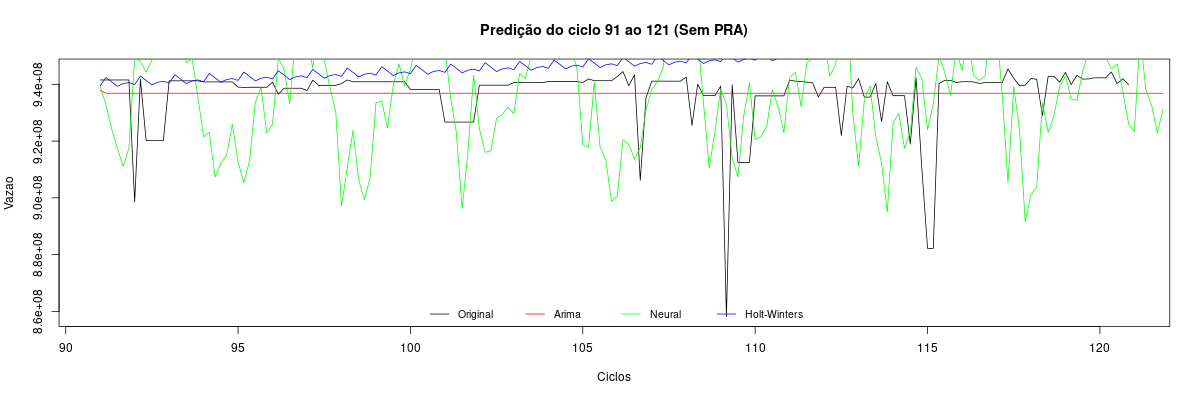

In [227]:
%%R -w 1200 -h 400

mini = min(c(mytsTest_without_PRA91_121, prevArima_without_PRA91_121$mean, prevNeural_without_PRA91_121$mean, prevHoltETS_without_PRA91_121$mean)) - 200000000
maxi = max(c(mytsTest_without_PRA91_121, prevArima_without_PRA91_121$mean, prevNeural_without_PRA91_121$mean, prevHoltETS_without_PRA91_121$mean)) + 15000
plot(mytsTest_without_PRA91_121, main= "Predição do ciclo 91 ao 121 (Sem PRA)", xlab="Ciclos", ylab="Vazao")
lines(prevArima_without_PRA91_121$mean, col="red")
lines(prevNeural_without_PRA91_121$mean, col="green")
lines(prevHoltETS_without_PRA91_121$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

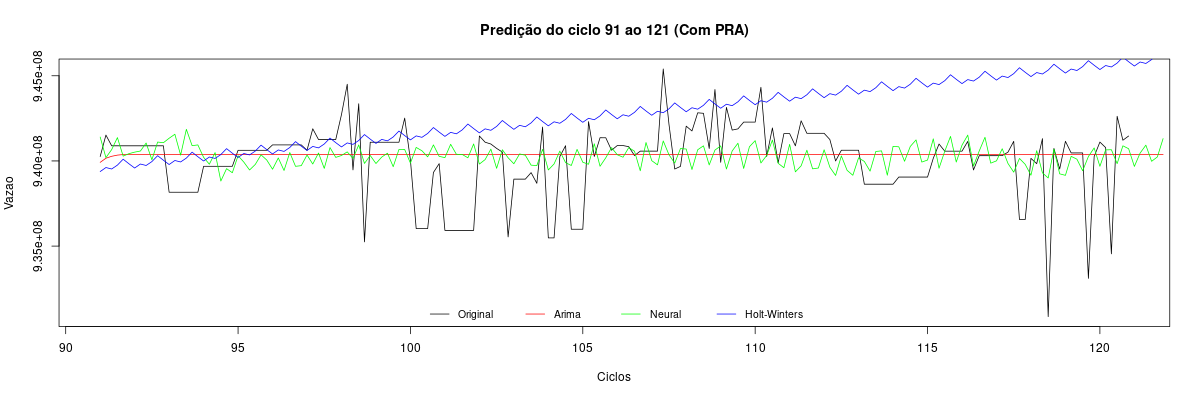

In [228]:
%%R -w 1200 -h 400

plot(mytsTest91_121, main= "Predição do ciclo 91 ao 121 (Com PRA)", xlab="Ciclos", ylab="Vazao")
lines(prevArima91_121$mean, col="red")
lines(prevNeural91_121$mean, col="green")
lines(prevHoltETS91_121$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)